# 基于内容的推荐（CB：content based）
https://blog.csdn.net/nicajonh/article/details/79657317

### CB的过程一般包括以下三步：

1. Item Representation：为每个item抽取出一些特征（也就是item的content了）来表示此item；

2. Profile Learning：利用一个用户过去喜欢（及不喜欢）的item的特征数据，来学习出此用户的喜好特征（profile）；

3. Recommendation Generation：通过比较上一步得到的用户profile与候选item的特征，为此用户推荐一组相关性最大的item。

[3]中对于上面的三个步骤给出一张很细致的流程图（第一步对应着Content Analyzer，第二步对应着Profile Learner，第三步对应着Filtering Component）：

#### 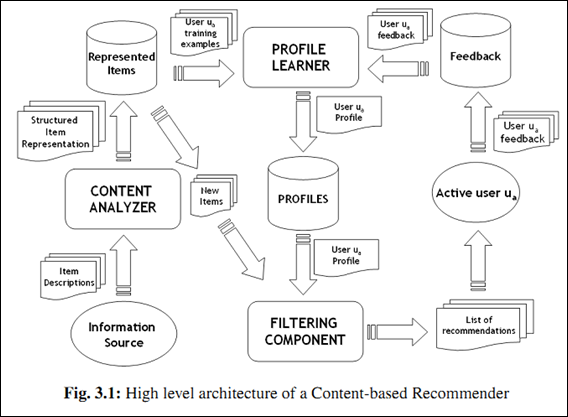

## Profile Learning
假设用户u已经对一些item给出了他的喜好判断，喜欢其中的一部分item，不喜欢其中的另一部分。那么，这一步要做的就是通过用户u过去的这些喜好判断，为他产生一个模型。有了这个模型，我们就可以根据此模型来判断用户u是否会喜欢一个新的item。所以，我们要解决的是一个典型的有监督分类问题，理论上机器学习里的分类算法都可以照搬进这里。


### 常用分类算法

1、最临近knn：对于一个新的item，从历史数据查找用户评判过的item中（包括喜欢和不喜欢），与新项目最接近的k个，根据用户对这k个项目的喜好进行推荐。对于这个方法，比较关键的可能就是如何通过item的属性向量计算item之间的两两相似度。[2]中建议对于结构化数据，相似度计算使用欧几里得距离；而如果使用向量空间模型（VSM）来表示item的话，则相似度计算可以使用cosine。

2、Rocchio算法：计算用户的偏好，给定一个新的item，计算其与偏好向量的相似度，在用户反馈之后，利用新项目的喜好，更新用户偏好。Rocchio算法的一个好处是可以根据用户的反馈实时更新，其更新代价很小。

3、决策树DT：当item的属性较少而且是结构化属性时，决策树一般会是个好的选择。这种情况下决策树可以产生简单直观、容易让人理解的结果。而且我们可以把决策树的决策过程展示给用户u，告诉他为什么这些item会被推荐。但是如果item的属性较多，且都来源于非结构化数据（如item是文章），那么决策树的效果可能并不会很好。

4、线性分类器LC：比梯度下降，Logistics Regression，Linear svm

5、朴素贝叶斯NB：NB经常被用来做文本分类，它假设在给定一篇文章的类别后，其中各个词出现的概率相互独立。它的假设虽然很不靠谱，但是它的结果往往惊人地好。再加上NB的代码实现比较简单，所以它往往是很多分类问题里最先被尝试的算法。我们现在的profile learning问题中包括两个类别：用户u喜欢的item，以及他不喜欢的item。在给定一个item的类别后，其各个属性的取值概率互相独立。我们可以利用用户u的历史喜好数据训练NB，之后再用训练好的NB对给定的item做分类。


In [43]:
import numpy as np
import pandas as pd

df = pd.read_csv("C:/Pdata/shixi/ml-latest-small/movies.csv")

In [39]:
#分隔tags
tags=df["genres"].str.split("|",expand=False)

#合并去重
myList=[y for x in tags for y in x]
tags_all=list(set(myList))
#生成标签矩阵
for i in tags_all:
    df[i]=df["genres"].str.contains(i)+0

C:\Users\yiyizhl\AppData\Local\conda\conda\envs\py3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


### 更方便的办法是使用one hot编码
    X=df["genres"].str.get_dummies(sep="|")   #default “|”

In [40]:
df[0:3]

,movieId,title,genres,Drama,Crime,Mystery,Documentary,Horror,War,Romance,...,Children,Action,Thriller,Sci-Fi,IMAX,Musical,Film-Noir,Animation,Comedy,Fantasy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [4]:
#newId=list(range(1,len(df)+1))
#df['movieId']=newId

### 研究用户1的喜好

In [5]:
df_user = pd.read_csv("C:/Pdata/shixi/ml-latest-small/ratings.csv",nrows=20)
df_user['prefile']=(df_user['rating']>=2.5)+0
df_user[0:3]

,userId,movieId,rating,timestamp,prefile
0,1,31,2.5,1260759144,1
1,1,1029,3.0,1260759179,1
2,1,1061,3.0,1260759182,1


### 合并用户和电影

In [6]:
df_merge=pd.merge(df_user,df,how='right', left_on='movieId',right_on='movieId')[0:20]
df_merge[0:3]

,userId,movieId,rating,timestamp,prefile,title,genres,Drama,Crime,Mystery,...,Children,Action,Thriller,Sci-Fi,IMAX,Musical,Film-Noir,Animation,Comedy,Fantasy
0,1.0,31,2.5,1.260759e+09,1.0,Dangerous Minds (1995),Drama,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1029,3.0,1.260759e+09,1.0,Dumbo (1941),Animation|Children|Drama|Musical,1,0,0,...,1,0,0,0,0,1,0,1,0,0
2,1.0,1061,3.0,1.260759e+09,1.0,Sleepers (1996),Thriller,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### 分训练集和测试集

In [7]:
from sklearn import cross_validation as cv;
train_data, test_data = cv.train_test_split(df_merge, test_size=0.2)#分测试集和训练集
train_data[0:3]

C:\Users\yiyizhl\AppData\Local\conda\conda\envs\py3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,userId,movieId,rating,timestamp,prefile,title,genres,Drama,Crime,Mystery,...,Children,Action,Thriller,Sci-Fi,IMAX,Musical,Film-Noir,Animation,Comedy,Fantasy
17,1.0,2455,2.5,1.260759e+09,1.0,"Fly, The (1986)",Drama|Horror|Sci-Fi|Thriller,1,0,0,...,0,0,1,1,0,0,0,0,0,0
1,1.0,1029,3.0,1.260759e+09,1.0,Dumbo (1941),Animation|Children|Drama|Musical,1,0,0,...,1,0,0,0,0,1,0,1,0,0
14,1.0,2150,3.0,1.260759e+09,1.0,"Gods Must Be Crazy, The (1980)",Adventure|Comedy,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### 使用决策树进行训练

In [8]:
from sklearn import tree


In [11]:
X=train_data.loc[:,"Drama":"Fantasy"]
Y=train_data.loc[:,"prefile"]

### 生成树

In [12]:
clf = tree.DecisionTreeClassifier(criterion='gini')
clf = clf.fit(X, Y)
print("clf: ", str(clf))

clf:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


### 可视化

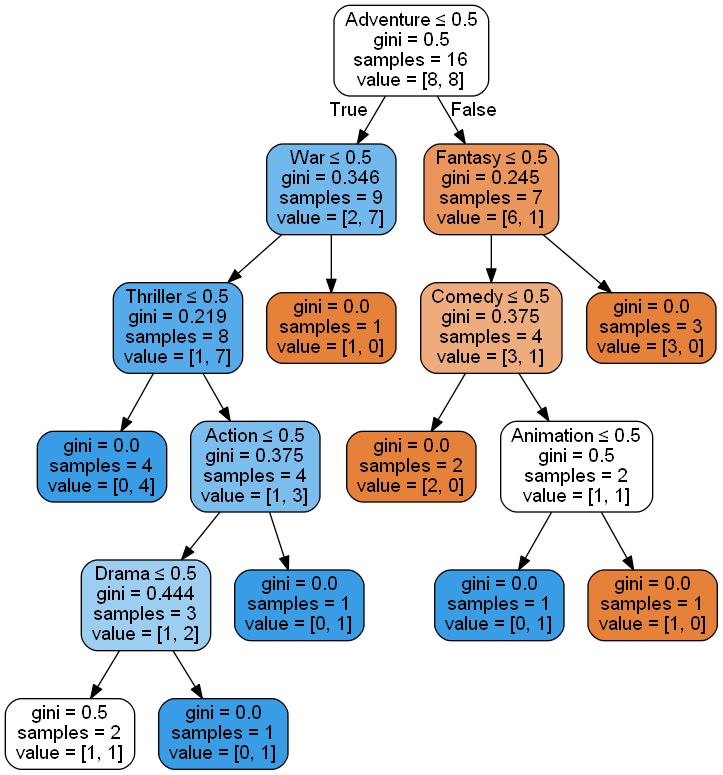

In [15]:
import pydotplus
from IPython.display import Image
feature_names=list(df_merge)[7:]
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=feature_names,   
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

#### 预测效果

In [22]:
predic=clf.predict(test_data.loc[:,"Drama":"Fantasy"])
groundtruth=test_data.loc[:,"prefile"]

In [33]:
print("预测结果是：%s,实际结果是%s"%(predic,list(groundtruth)))

预测结果是：[0. 0. 0. 1.],实际结果是[1.0, 1.0, 1.0, 0.0]


### 结果完败。。。果然只靠电影类型预测是不行的，不过主要也就是练练方法，具体的特征提取需要机器学习来做

In [34]:
clf.predict_proba(test_data.loc[:,"Drama":"Fantasy"])

array([[1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [0. , 1. ]])

In [42]:
X=df["genres"].str.get_dummies(sep="|")
X

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
